# OSCAR, a Tech Preview (Part I)

A tiny example, which makes use of the cornerstone systems polymake and GAP.

## The Setup

The configuration can be cloned via copying the <i>Project.toml</i> file and using <i>instantiate</i> in the REPL mode.

In [1]:
versioninfo()

using Pkg
Pkg.status()

Julia Version 1.5.3
Commit 788b2c77c1 (2020-11-09 13:37 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-7600U CPU @ 2.80GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)
Status `/data/polymake/oscar-system/oscar-notebooks/MPI-demo-200124/Project.toml`
  [7073ff75] IJulia v1.23.1
  [f1435218] Oscar v0.5.1 `https://github.com/oscar-system/Oscar.jl#d0908f5`
→ [9b87118b] PackageCompiler v1.2.5
  [8f399da3] Libdl
Info packages marked with → not downloaded, use `instantiate` to download


## polymake's Functions Are Available

In [2]:
using Oscar
const pm=Polymake;

 -----    -----    -----      -      -----   
|     |  |     |  |     |    | |    |     |  
|     |  |        |         |   |   |     |  
|     |   -----   |        |     |  |-----   
|     |        |  |        |-----|  |   |    
|     |  |     |  |     |  |     |  |    |   
 -----    -----    -----   -     -  -     -  

...combining (and extending) ANTIC, GAP, Polymake and Singular
Version 0.5.1 ... 
 ... which comes with absolutely no warranty whatsoever
Type: '?Oscar' for more information
(c) 2019-2021 by The Oscar Development Team


In the context of Hilbert's 16th Problem Itenberg and Viro constructed a counter-example to a conjecture of Ragsdale, via <i>patchworking</i>.  This is just to show that (almost) all of polymake's functionality is available through Julia.

In [3]:
R = pm.tropical.ragsdale_counterexample();

Interactive visualization is possible, also within a Jupyter notebook.  Yet, for static web versions svg output is nicer.

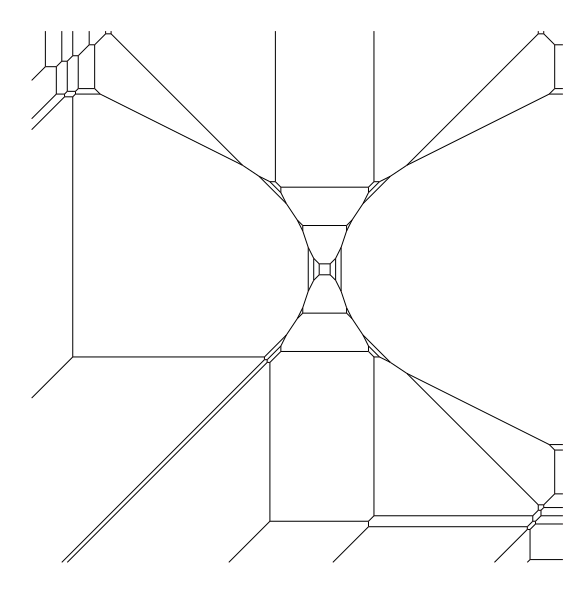

In [4]:
pm.display_svg(R)

The actual example starts here.  We construct a regular $4$-cube, with $\pm1$-coordinates, but the precise coordinates will not matter here.

In [5]:
C = pm.polytope.cube(4);

We can get the combinatorial automorphism group directly.

In [6]:
G_polymake = pm.group.automorphism_group(C.VERTICES_IN_FACETS);

From the type information output (which is suppressed by ";" following the command) we see that the group is given as a permutation group.  What is not obvious, but true: this is the natural action on the eight facets.

In [7]:
gens = G_polymake.PERMUTATION_ACTION.GENERATORS

pm::Array<pm::Array<long>>
0 1 2 3 6 7 4 5
0 1 4 5 2 3 6 7
2 3 0 1 4 5 6 7
1 0 2 3 4 5 6 7


Note that polymake is $0$-based, while Julia is $1$-based.

In [8]:
gens[2]

pm::Array<long>
0 1 4 5 2 3 6 7

Generic Julia functions can convert between $0$- and $1$-based containers.  Future Polymake.jl versions will have this built-in.

In [9]:
to_one_based_indexing(n::Number) = n + one(n)
to_zero_based_indexing(n::Number) = (n > zero(n) ? n - one(n) : throw(ArgumentError("Can't use negative index")))

for f in [:to_one_based_indexing, :to_zero_based_indexing]
    @eval begin
        $f(itr) = $f.(itr)
        $f(s::S) where S<:AbstractSet = S($f.(s))
    end
end

Applying this to the generators of the group computed by polymake yields a standard Julia datatype.

In [10]:
to_one_based_indexing(gens)

4-element Array{Array{Int64,1},1}:
 [1, 2, 3, 4, 7, 8, 5, 6]
 [1, 2, 5, 6, 3, 4, 7, 8]
 [3, 4, 1, 2, 5, 6, 7, 8]
 [2, 1, 3, 4, 5, 6, 7, 8]

## Use GAP For Groups

The software of choice to deal with groups is GAP.  Here is a micro-demo, which constructs a symmetric group of degree four from a 4-cycle and a transposition.

In [11]:
S4 = GAP.Globals.Group(GAP.@gap [(1,2,3,4), (1,2)])
@show S4
GAP.Globals.Order(S4)

S4 = GAP: Group([ (1,2,3,4), (1,2) ])


24

A typical OSCAR-function will provide natural ways of communication between the cornerstone systems.  The function is fairly short, the bulk of the code are some straightforward conversions.

In [12]:
function combinatorial_automorphism_group(P)
    G = pm.group.automorphism_group(P.VERTICES_IN_FACETS)
    gens_polymake = G.PERMUTATION_ACTION.GENERATORS # acting on the facets
    gens_julia = Vector{Int64}.(pm.to_one_based_indexing(gens_polymake))
    gens_gap = GAP.Globals.PermList.(GAP.julia_to_gap.(gens_julia))
    return GAP.Globals.Group(gens_gap...)
end

combinatorial_automorphism_group (generic function with 1 method)

Recognizing the isomorphism type of the (combinatorial) automorphism group of a polytope is available neither in GAP nor polymake alone.

In [13]:
G = combinatorial_automorphism_group(C)
GAP.Globals.StructureDescription(G)

GAP: "((((C2 x C2 x C2) : (C2 x C2)) : C3) : C2) : C2"

Some functions are implemented independently in both systems.  This can be employed for cross-certification.

In [14]:
@show G_polymake.ORDER
@show GAP.Globals.Order(G)

G_polymake.ORDER = 384
GAP.Globals.Order(G) = 384


384